In [ ]:
pip install ipyleaflet

In [29]:
pip install ipyvolume

  Using cached ipyvolume-0.5.2-py2.py3-none-any.whl (2.9 MB)
  Using cached ipywebrtc-0.6.0-py2.py3-none-any.whl (260 kB)
  Using cached pythreejs-2.3.0-py2.py3-none-any.whl (3.4 MB)
  Using cached ipydatawidgets-4.3.1.post1-py2.py3-none-any.whl (271 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install matplotlib

In [ ]:
pip install pandas

In [ ]:
pip install pyproj

In [ ]:
pip install ipyvolume

In [ ]:
pip install shapely

In [ ]:
pip install scipy

In [ ]:
#pip install pdal

In [ ]:
pip install requests

In [1]:
import pyproj
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import json
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
#import pdal
import PIL
import requests
import shapely.geometry
import scipy.spatial
import sys
import urllib.request
import shapely

In [2]:
m = ipyleaflet.Map(center=(46.459222, 6.922641), zoom=15)
dc = ipyleaflet.DrawControl()
m.add_control(dc)
m

Map(center=[46.459222, 6.922641], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

POLYGON ((2560632.6993575804 1145560.2259080147, 2560541.755142928 1145515.6880666723, 2560639.843470595 1145395.8733716435, 2560726.8553181915 1145473.344002537, 2560632.6993575804 1145560.2259080147))


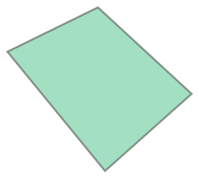

In [3]:
wsg84 = 'epsg:4326'
ch1903plus= 'epsg:2056'
from pyproj import Transformer
transformer = Transformer.from_crs(wsg84, ch1903plus)
coords = [transformer.transform(y,x) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
polygon = shapely.geometry.Polygon(coords)
print(polygon.wkt)
IPython.display.display(polygon)


In [4]:
lidar_filename = "2560_1145.las"

In [5]:
import pdal
b = polygon.bounds
cropper = {
    "pipeline": [lidar_filename,
        {   "type":"filters.crop",
            'bounds':str(([b[0], b[2]],[b[1], b[3]]))},
        {   "type":"filters.crop",
            'polygon':polygon.wkt},
        #{   "type":"filters.hag"},
        {   "type":"filters.eigenvalues",
            "knn":16},
        {   "type":"filters.normal",
            "knn":16}
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
#pipeline.validate()
%time n_points = pipeline.execute()

#print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon.area))

CPU times: total: 12.9 s
Wall time: 13 s


In [6]:
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon.area))

Pipeline selected 254022 points (16.9 pts/m2)


In [7]:
# Load Pipeline output in python objects
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [19]:
fig = p3.figure(width=600)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(df['Y'], df['Z'], df['X'], color='red', size=.2)
p3.squarelim()
p3.show()

In [16]:
%%javascript
// prevent click on the widget to jump throughout the notebook
$(".jupyter-widgets-view").click(function(e){e.stopPropagation();})

<IPython.core.display.Javascript object>

In [20]:
# Color ground in grey
df['ground'] = df['Classification']==2
ground = p3.scatter(df.loc[df['ground'],'Y'].values, df.loc[df['ground'],'Z'].values, df.loc[df['ground'],'X'].values, color='red', size=.2)
non_ground = p3.scatter(df.loc[~df['ground'],'Y'].values, df.loc[~df['ground'],'Z'].values, df.loc[~df['ground'],'X'].values, color='red', size=.2)
fig.scatters.append(ground)
#fig.scatters.append(non_ground)
all_points.visible = False
ground.color='lightgrey'

In [21]:
# Show ground as surface
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

In [22]:
# Show ground as surface
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

In [23]:
# Color points according to flatness
df['flatness'] = df['Eigenvalue0'] 
non_ground.color=matplotlib.cm.viridis(df.loc[~df['ground'],'flatness']*4)[:,0:3]

In [26]:
# Separate between trees and the rest
df['tree_potential'] = df['Classification']==3 
df['other'] = ~df['ground'] & ~df['tree_potential']
tree_potential = p3.scatter(df.loc[df['tree_potential'],'Y'].values, df.loc[df['tree_potential'],'Z'].values, df.loc[df['tree_potential'],'X'].values, color=matplotlib.cm.viridis(df.loc[df['tree_potential'],'flatness']*4)[:,0:3], size=.2)
other = p3.scatter(df.loc[df['other'],'Y'].values, df.loc[df['other'],'Z'].values, df.loc[df['other'],'X'].values, color=matplotlib.cm.viridis(df.loc[df['other'],'flatness']*4)[:,0:3], size=.2)
non_ground.visible=False
tree_potential.color='darkgreen'
other.color='red'

In [27]:
#Hide non-tree
other.visible=False

In [28]:
lep = local_max(df.loc[df['tree_potential'],['X','Y','Z','HeightAboveGround']], radius=3, density_threshold=15)

NameError: name 'local_max' is not defined